In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import copy
import random
from matplotlib import pyplot as plt
import numpy as np
#From keras
import keras
from keras.models import load_model
# from keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from keras import optimizers
from keras.utils import multi_gpu_model
from keras import backend as K
from keras.callbacks import *
# From ssd_keras
from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
import ssd_encoder_decoder.ssd_output_decoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections
from SSD_loss import SSDLoss
from eval_utils.average_precision_evaluator import Evaluator
from importlib import reload
#import cv2
from data_augment import LabelEncoder
from detector_help import process_y,post_process,prior_box
import detection_nets,classification_nets
import tensorflow as tf
from matplotlib import pyplot as plt
from drawing import *
from detection_nets import load_mobilenetv2
%matplotlib inline
import debug_model

### Set model config

In [9]:
input_H = 300
input_W = 300
input_C = 3
input_shape = (input_H, input_W, input_C)
model_name = "rfblite_d_mn2_300"
root_path = "/home/cai/dataset/VOCdevkit"
aspect_ratios = [[2,3],
                 [2,3],
                 [2,3],
                 [2,3],
                 [2],
                 [2]]
prior_config =  [2 + len(ar) * 2 for ar in aspect_ratios]  # number of boxes per feature map location
source_layers = ["block_12_expand"] #["block_6_expand","block_12_expand"]
#Extra layer head:  
#rfblite_d  rfblite_d, oup, dilation_base, dilation_rate, only_bone,source
#plain      oup, stride,pad,source
extra_config = [
               ['literfb_d',512, 1,  2, False, True],
               [256, 2, 'same', True],
               [256,  1, 'same', True],
               [128,  1, 'valid', True]]
source_config = [['literfb_d',96, 1, 2,  False]]
mean_color = [123, 117, 104] 
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
num_classes = 20 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
variances = [0.1, 0.1, 0.2, 0.2]
# scale = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05]
scale = [0.07, 0.17, 0.33, 0.51, 0.67, 0.87, 1.05]

In [3]:
reload(detection_nets)
##Load basenet first
K.clear_session()
base_model = load_mobilenetv2(size = 300)
build_model = detection_nets.build_RFBLite
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3,alpha=1.0)

model = build_model(input_shape = (300,300,3),
              phase = 'train',
              source_layers = source_layers,
              base_model = base_model,
              extra_config = extra_config,
              source_config = source_config,
              include_base = True,
              base_index = -1,
              source_expand_ratio = 1,
              source_dep_mul = 1,
              prior_config = prior_config,
              num_classes = num_classes,
              lite = True,
              return_predictor = True)

model.summary()                       #Comment this line if you don`t want to show summary every time you build your model
# model.load_weights("saved_weights/BEST_rfblite_mn2_300_b_pascal_07+12_epoch-122_loss-2.1461_val_loss-2.6892.h5",by_name = True)
# print(get_flops())
model = detection_nets.preprocess(input_shape,model,mean_color,swap_channels)
# model = multi_gpu_model(model,gpus=gpus) #Comment it if don`t use multi_gpu 

#Don`t tune learning rate here because we will use a lr scheduler in callbacks
#Orignal paper used SGD but according to the author of ssd_keras, use adam is better 
model.compile(adam,
              loss=ssd_loss.loss,
              metrics = [ssd_loss.class_loss,ssd_loss.loc_loss]
              )
print(model_name,'has been built ')

/home/cai/.local/lib/python3.5/site-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[256, 2, 'same', True]
[256, 1, 'same', True]
[128, 1, 'valid', True]
[[19 19]
 [10 10]
 [10 10]
 [ 5  5]
 [ 5  5]
 [ 3  3]]
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 301, 301, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 150, 150, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 150, 150, 32) 128         C

rfblite_mn2_300_inverted redisual has been built 


## Show a analysis of params 

[['rfb_source_0_conv1_1_sep' 32832
  <tf.Tensor 'block_12_expand/convolution:0' shape=(?, 19, 19, 576) dtype=float32>
  list([None, 19, 19, 48])]
 ['rfb_source_0_conv2_1_sep' 32832
  <tf.Tensor 'block_12_expand/convolution:0' shape=(?, 19, 19, 576) dtype=float32>
  list([None, 19, 19, 48])]
 ['rfb_source_0_conv1_1_bn' 192
  <tf.Tensor 'rfb_source_0_conv1_1_sep/Relu:0' shape=(?, 19, 19, 48) dtype=float32>
  list([None, 19, 19, 48])]
 ['rfb_source_0_conv2_1_bn' 192
  <tf.Tensor 'rfb_source_0_conv2_1_sep/Relu:0' shape=(?, 19, 19, 48) dtype=float32>
  list([None, 19, 19, 48])]
 ['rfb_source_0_concatenate' 0
  list([<tf.Tensor 'rfb_source_0_conv1_1_bn/cond/Merge:0' shape=(?, 19, 19, 48) dtype=float32>, <tf.Tensor 'rfb_source_0_conv2_1_bn/cond/Merge:0' shape=(?, 19, 19, 48) dtype=float32>])
  list([None, 19, 19, 96])]]


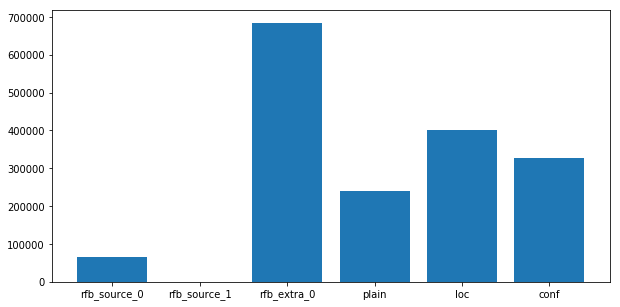

In [4]:
reload(debug_model)
keys = ["rfb_source_0","rfb_source_1","rfb_extra_0","plain","loc","conf"] 
debug_model.model_params_bar(model,16*9+4,len(model.layers),0,keys = keys)
debug_model.model_params_of_layer(model,16*9+4,len(model.layers),0,key = 'rfb_source_0')

### Load previously trained models 

In [ ]:
K.clear_session() # Clear previous models from memory.

model_path = "saved_weights/rfblite_mn2_300_b_pascal_07+12_epoch-122_loss-2.1461_val_loss-2.6892.h5"
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3,alpha=1.0)

# model.load_weights(model_path)
# model = multi_gpu_model(model,gpus=2) #Comment it if don`t use multi_gpu 
model = load_model(model_path,custom_objects={'loss': ssd_loss.loss,'class_loss':ssd_loss.class_loss,'loc_loss':ssd_loss.loc_loss})
print("load model from",model_path)   

### Speed Test(optional)

In [ ]:
import time
batch_n = 100
img_height = 300
img_width = 300
img_channels = 3
# detector = Detect(num_classes,0,cfg)
batch_size_range = [1,2,4,8]#[1,2,4,8]
print('Start testing...')
for batch_size in batch_size_range:
    time_total = 0
    time_net = 0
    time_post = 0
    print('batch size',batch_size)
    for i in range(0,batch_n):
        test_batch = np.random.rand(batch_size,img_height,img_width,img_channels)
        click = time.time()
        y_pred = model.predict(test_batch)
        time_net += (time.time() - click)
        click = time.time()
        y_pred_decoded = decode_detections(y_pred,
                          priors,variances,
                          img_height = input_H,
                          img_width = input_W,
                          confidence_thresh = 0.5,
                          iou_threshold = 0.45)
        time_post += (time.time() - click)
    time_total = time_net + time_post
    print('Time cost per batch: %.3f FPS: %.1f'%(time_total / batch_n,batch_n*batch_size/ time_total))
    print('Time(pure forward) cost per batch: %.3f FPS: %.1F'%(time_net / batch_n, batch_n*batch_size/ time_net))
batch_size = None
          

### Data config

In [5]:

#Define class_names
class_names = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

force_create_dataset = False #Force data generator to load dataset from source
root_path = '/home/cai/dataset/VOCdevkit'
trainset_hdf5_path = 'dataset_pascal_voc_07+12_trainval.h5'
valset_hdf5_path = 'dataset_pascal_voc_07_test.h5'

# The directories that contain the images.
VOC_2007_images_dir      = root_path + '/VOC2007/JPEGImages/'
VOC_2012_images_dir      = root_path + '/VOC2012/JPEGImages/'

# The directories that contain the annotations.
VOC_2007_annotations_dir      = root_path + '/VOC2007/Annotations/'
VOC_2012_annotations_dir      = root_path + '/VOC2012/Annotations/'

# The paths to the image sets.
VOC_2007_train_image_set_filename    = root_path + '/VOC2007/ImageSets/Main/train.txt'
VOC_2012_train_image_set_filename    = root_path + '/VOC2012/ImageSets/Main/train.txt'
VOC_2007_val_image_set_filename      = root_path + '/VOC2007/ImageSets/Main/val.txt'
VOC_2012_val_image_set_filename      = root_path + '/VOC2012/ImageSets/Main/val.txt'
VOC_2007_trainval_image_set_filename = root_path + '/VOC2007/ImageSets/Main/trainval.txt'
VOC_2012_trainval_image_set_filename = root_path + '/VOC2012/ImageSets/Main/trainval.txt'
VOC_2007_test_image_set_filename     = root_path + '/VOC2007/ImageSets/Main/test.txt'

## Load Dataset

In [6]:
if os.path.isfile(trainset_hdf5_path) and os.path.isfile(valset_hdf5_path) and not force_create_dataset:
    #Load dataset from created hdf5_dataset
    train_dataset = DataGenerator(hdf5_dataset_path = trainset_hdf5_path)
    val_dataset = DataGenerator(hdf5_dataset_path = valset_hdf5_path)
else:
    train_dataset = DataGenerator()
    val_dataset = DataGenerator()
    
    train_dataset.parse_xml(images_dirs=[VOC_2007_images_dir,
                                         VOC_2012_images_dir],
                            image_set_filenames=[VOC_2007_trainval_image_set_filename,
                                                 VOC_2012_trainval_image_set_filename],
                            annotations_dirs=[VOC_2007_annotations_dir,
                                              VOC_2012_annotations_dir],
                            classes=class_names,
                            include_classes='all',
                            exclude_truncated=False,
                            exclude_difficult=False,
                            ret=False)

    val_dataset.parse_xml(images_dirs=[VOC_2007_images_dir],
                          image_set_filenames=[VOC_2007_test_image_set_filename],
                          annotations_dirs=[VOC_2007_annotations_dir],
                          classes=class_names,
                          include_classes='all',
                          exclude_truncated=False,
                          exclude_difficult=True,
                          ret=False)
    train_dataset.create_hdf5_dataset(file_path=trainset_hdf5_path,
                                      resize=False,
                                      variable_image_size=True,
                                      verbose=True)

    val_dataset.create_hdf5_dataset(file_path=valset_hdf5_path,
                                    resize=False,
                                    variable_image_size=True,
                                    verbose=True)

Loading evaluation-neutrality annotations: 100%|██████████| 4952/4952 [00:00<00:00, 6213.64it/s]


## Data Augment 

In [15]:
import detector_help
reload(detector_help)
from detector_help import *
import data_augment
reload(data_augment)
from data_augment import *

batch_size = 32
ssd_data_augmentation = SSDDataAugmentation(img_height=input_H,
                                            img_width=input_W,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=input_H, width=input_W)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.

feature_map = [layer.output.shape.as_list()[1:3] for layer in model.layers[-1].layers if ('loc_' in layer.name and 'sep' in layer.name)]
priors = prior_box(feature_map,aspect_ratios,scale = scale)
label_encoder = LabelEncoder(num_classes,priors,variances,input_H,input_W)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=label_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=label_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()
print("Feature map:",feature_map)
print("Number of priors:\t{:>6}".format(len(priors)))
print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Feature map: [[19, 19], [10, 10], [10, 10], [5, 5], [5, 5], [3, 3]]
Number of priors:	  3652
Number of images in the training dataset:	 16551
Number of images in the validation dataset:	  4952


## Draw a batch of images(optional)

In [16]:
import drawing
reload(drawing)
from drawing import *
train_flow_origin = train_dataset.generate(batch_size = 4,
                                           transformations=[], 
                                           label_encoder = label_encoder,
                                           returns = ['original_images','original_labels'])
images,labels = next(train_flow_origin)
for img,label in zip(images, labels):
    draw_detection(img,label,class_names,pred_format = {"class":0,"xmin":1,"ymin":2,"xmax":3,"ymax":4})           

KeyboardInterrupt: 

### Set training params

In [17]:
#If load weights from files,initial_epoch need to be set to the next epoch to be trained.
initial_epoch = 0
final_epochs = 120
steps_per_epoch = 1000
plot = True

## Define callback function

In [18]:
#1. Set file path
weights_folder = 'saved_weights/'

if not os.path.isdir(weights_folder):
    os.mkdir(weights_folder)

checkpoint_filepath = weights_folder + model_name + '_pascal_07+12_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5'
log_filepath = "training_summaries/" +model_name + '_pascal_07+12_training_log.csv' 
#2. Define a lr_scheduler

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=8,
                                         verbose=1,
                                         epsilon=0.001,
                                         cooldown=0,
                                         min_lr=0.00001)    
#3. ## Define callbacks
model_checkpoint = ModelCheckpoint(filepath = checkpoint_filepath,
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=True,
                                   mode='auto',
                                   period=5)

csv_logger = CSVLogger(filename=log_filepath,
                           separator=',',
                           append=True)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             reduce_learning_rate,
             terminate_on_nan]
# callbacks = [csv_logger,learning_rate_scheduler]

/home/cai/.local/lib/python3.5/site-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


## Train the model

In [ ]:
print('model name' ,model_name , \
       '\nstart fitting.. ' , 
       'inital epoch:', initial_epoch,
       'final epoch:', final_epochs,
       'epoch step:', steps_per_epoch,
       'plot_history:' ,plot, \
       '\ntrainset size:',  train_dataset.get_dataset_size(), ' batch_size', batch_size )     

validation_steps =  val_dataset.get_dataset_size() // batch_size
history = model.fit_generator(train_generator,
                              use_multiprocessing = False, 
                              steps_per_epoch = steps_per_epoch, 
                              validation_data = val_generator,
                              validation_steps = validation_steps, 
                              epochs = final_epochs,
                              callbacks = callbacks,
                              initial_epoch = initial_epoch)

if plot:
    plot_history(history)
    plt.savefig('./%s_pascal07+12.jpg'%model_name)



model name rfblite_d_mn2_300 
start fitting..  inital epoch: 0 final epoch: 120 epoch step: 1000 plot_history: True 
trainset size: 16551  batch_size 32
Epoch 1/120


## Evaluate

### mAP 

In [ ]:
import eval_utils.average_precision_evaluator
reload(eval_utils.average_precision_evaluator)
from eval_utils.average_precision_evaluator import Evaluator

In [ ]:
test_dataset = DataGenerator()
test_dataset.parse_xml(images_dirs=[VOC_2007_images_dir],
                      image_set_filenames=[VOC_2007_test_image_set_filename],
                      annotations_dirs=[VOC_2007_annotations_dir],
                      classes=class_names,
                      include_classes='all',
                      exclude_truncated=False,
                      exclude_difficult=False,
                      ret=False)

print('Test size', test_dataset.get_dataset_size())

In [ ]:
evaluator = Evaluator(model=model,
                      n_classes=num_classes,
                      data_generator=test_dataset,
                      model_mode='training')

results = evaluator(img_height=input_H,
                    img_width=input_W,
                    batch_size=batch_size,
                    priors = priors,
                    variances = variances,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

In [ ]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(class_names[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

In [ ]:
m = max((num_classes + 1) // 2, 2)
n = 2

fig, cells = plt.subplots(m, n, figsize=(n*8,m*8))
for i in range(m):
    for j in range(n):
        if n*i+j+1 > num_classes: break
        cells[i, j].plot(recalls[n*i+j+1], precisions[n*i+j+1], color='blue', linewidth=1.0)
        cells[i, j].set_xlabel('recall', fontsize=14)
        cells[i, j].set_ylabel('precision', fontsize=14)
        cells[i, j].grid(True)
        cells[i, j].set_xticks(np.linspace(0,1,11))
        cells[i, j].set_yticks(np.linspace(0,1,11))
        cells[i, j].set_title("{}, AP: {:.3f}".format(class_names[n*i+j+1], average_precisions[n*i+j+1]), fontsize=16)

### Predict

In [ ]:
# 1: Set the generator for the predictions.

predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[convert_to_3_channels,
                                                          resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

In [ ]:

# Generate batch_items
batch_images, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

i = 0 # Which batch item to look at

#print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))


# 3: Make predictions.
y_pred = model.predict(batch_images)

In [ ]:
# 4: Decode labels
reload(detector_help)
# y_pred_decoded = decode_detections(y_pred,
#                   priors,variances,
#                   img_height = input_H,
#                   img_width = input_W,
#                   confidence_thresh = 0.5,
#                   iou_threshold = 0.45)
prior_pyramid = detector_help.prior_id_rank(feature_map=feature_map,prior_config=prior_config)
y_pred_decoded = detector_help.post_process(y_pred, 
                                            priors,
                                            variances,
                                            num_classes,
                                            input_H, 
                                            input_W,
                                            prior_pyramid,
                                            score_thresh = 0.1,
                                            iou_thresh = 0.4)
y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)
np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax  map_id')
print(y_pred_decoded_inv[i])

In [ ]:
# 5: Draw 
colors = plt.cm.hsv(np.linspace(0, 1, num_classes+1)).tolist()
draw_detection(batch_original_images[i],y_pred_decoded_inv[i],class_names,
               show = True, draw_score = True,use_cm = True,color = colors, size = 'medium')
draw_detection(batch_original_images[i],batch_original_labels[i],class_names, size = 'medium')


### Image Demo

In [ ]:
img_file = "data/dog3.jpg"
img = cv2.imread(img_file)
img = cv2.resize(img,(224,224))
x = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = np.array(x,dtype='float')
x = x / 255
y_pred = model.predict(np.expand_dims(x,0))
y_pred = post_process(y_pred,priors,num_classes,input_H,input_W)
print(y_pred)
draw_detection(img,y_pred[0],class_names)

### Video detection demo

In [ ]:
video_file = "data/cat_video.mp4"
result_file = "res.avi"
cap= cv2.VideoCapture(video_file)
fps = cap.get(cv2.CAP_PROP_FPS)
size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
frames = (int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print('Input Video Size:',size,' Fps:',fps,' Frames:',frames)
writer = cv2.VideoWriter(result_file,cv2.VideoWriter_fourcc(*'MJPG'), fps, size)
success,frame = cap.read()
count = 1
while success:
    x = cv2.resize(frame,dsize=(input_H,input_W),interpolation=cv2.INTER_CUBIC)
    x = x / 255
    y_pred = model.predict(np.expand_dims(x,0))[0]
    y_pred [-4:] *= [*size,*size]
    draw_detection(frame, y_pred,class_names,font_scale = 1)
    writer.write(frame)
    cv2.waitKey(1)
    count += 1
    if count%50==0:
        print(y_pred)
        plt.imshow(frame)
        plt.show()
        print('.',end='')
    success,frame = cap.read()
print('done')